# Movie Recommendation Model

## Import Necessary Libraries & Load The Data

In [183]:
import numpy as np                          
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv
/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv


In [184]:
df1=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')

In [185]:
df2.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


## Movie Rating System

In [186]:
df2['vote_average'].head(4)


0    7.2
1    6.9
2    6.3
3    7.6
Name: vote_average, dtype: float64

### Mean Rating

In [187]:
C= df2['vote_average'].mean()
C

6.092171559442016

### Minimum Votes 

In [188]:
top = df2.copy().loc[df2['vote_count'] >= 600]
top.shape

(1407, 20)

### Movie Rating Function

(WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C where:

- R = average for the movie (mean) = (Rating)
- v = number of votes for the movie = (votes)
- m = minimum votes required to be listed in the Top 1000
- C = the mean vote across the whole report 

In [189]:
def weighted_rating(data, m=m, C=C):
    v = data['vote_count']
    R = data['vote_average']
    
    return (v/(v+m) * R) + (m/(m+v) * C) #  IMDB formula

In [190]:
top['score'] = top.apply(weighted_rating, axis=1)
top[['title', 'vote_count', 'vote_average', 'score']].sort_values("score", ascending=0).head(5)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.340775
3337,The Godfather,5893,8.4,8.192887
662,Fight Club,9413,8.3,8.171648
3232,Pulp Fiction,8428,8.3,8.157615
65,The Dark Knight,12002,8.2,8.102674


### Most Popular Movies

Text(0.5, 1.0, 'Popular Movies')

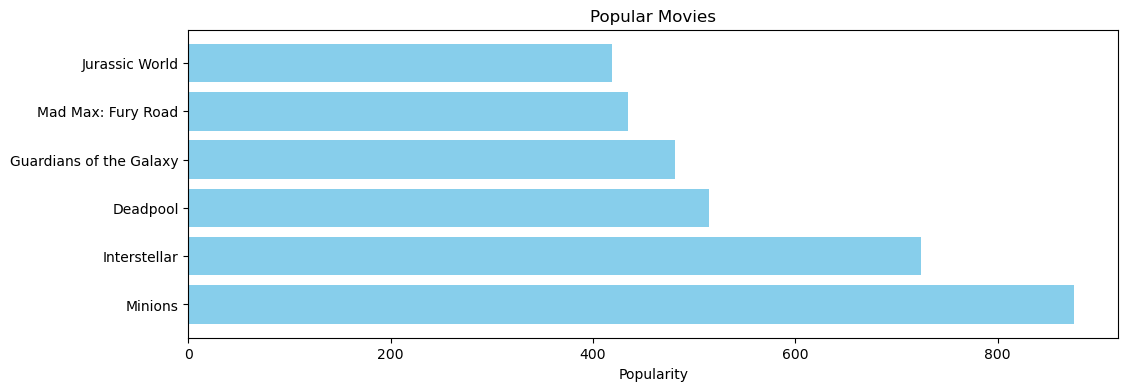

In [191]:
pop= df2.sort_values('popularity', ascending=False)

plt.figure(figsize=(12,4))
plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.xlabel("Popularity")
plt.title("Popular Movies")

## Content Recommendation System

### Text processing to convert the word vector of each overview (TF-IDF)

In [192]:
df2['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [193]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf = TfidfVectorizer(stop_words='english')
df2['overview'] = df2['overview'].fillna('')

tfidf_matrix = tfidf.fit_transform(df2['overview'])
tfidf_matrix.shape

(4803, 20978)

### Use cosine similarity to calculate similarity between two movies

In [194]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

### Make a function that returns Top 10 similar movies

In [195]:
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()
indices.head(3)

title
Avatar                                      0
Pirates of the Caribbean: At World's End    1
Spectre                                     2
dtype: int64

In [196]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return data['title'].iloc[movie_indices]

Let`s Try

In [197]:
get_recommendations('The Godfather')

,title,title
2731,The Godfather: Part II,The Godfather: Part II
1873,Blood Ties,Blood Ties
867,The Godfather: Part III,The Godfather: Part III
3727,Easy Money,Easy Money
3623,Made,Made
3125,Eulogy,Eulogy
3896,Sinister,Sinister
4506,The Maid's Room,The Maid's Room
3783,Joe,Joe
2244,The Cold Light of Day,The Cold Light of Day


In [198]:
get_recommendations('The Dark Knight').head(10)

,title,title
3,The Dark Knight Rises,The Dark Knight Rises
428,Batman Returns,Batman Returns
3854,"Batman: The Dark Knight Returns, Part 2","Batman: The Dark Knight Returns, Part 2"
299,Batman Forever,Batman Forever
1359,Batman,Batman
119,Batman Begins,Batman Begins
1181,JFK,JFK
9,Batman v Superman: Dawn of Justice,Batman v Superman: Dawn of Justice
2507,Slow Burn,Slow Burn
210,Batman & Robin,Batman & Robin


## Actors, Director, Genres Recommendation System

In [199]:
df1.columns

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

In [200]:
data = pd.concat([df1, df2], axis=1)

In [201]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    data[feature] = data[feature].apply(literal_eval)

###  Extract the required information

In [202]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [203]:
# Returns the list top 3 elements
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        
        if len(names) > 3:
            names = names[:3]
        return names

    
    return []

In [204]:
# Define new director, cast, genres and keywords features that are in a suitable form.
data['director'] = data['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    data[feature] = data[feature].apply(get_list)

In [205]:
data[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,title,cast,director,keywords,genres
0,Avatar,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


### Clean the Names 

In [206]:
# Function to convert all strings to lower case and strip spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [207]:
# Apply function 
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    data[feature] = data[feature].apply(clean_data)

### Create metadata

In [208]:
def create_metadata(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
data['soup'] = data.apply(create_metadata, axis=1)

### Create the count matrix

In [209]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(data['soup'])


from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)
# Reset index of our main DF
data = data.reset_index()
indices = pd.Series(data.index, index=df2['title'])

 Let`s try get_recommendations() by passing in the new cosine_sim2 matrix 

In [210]:
get_recommendations('The Godfather', cosine_sim2)

,title,title
867,The Godfather: Part III,The Godfather: Part III
2731,The Godfather: Part II,The Godfather: Part II
4638,Amidst the Devil's Wings,Amidst the Devil's Wings
2649,The Son of No One,The Son of No One
1525,Apocalypse Now,Apocalypse Now
1018,The Cotton Club,The Cotton Club
1170,The Talented Mr. Ripley,The Talented Mr. Ripley
1209,The Rainmaker,The Rainmaker
1394,Donnie Brasco,Donnie Brasco
1850,Scarface,Scarface


In [211]:
get_recommendations('The Dark Knight', cosine_sim2)

,title,title
3,The Dark Knight Rises,The Dark Knight Rises
119,Batman Begins,Batman Begins
4638,Amidst the Devil's Wings,Amidst the Devil's Wings
2398,Hitman,Hitman
1720,Kick-Ass,Kick-Ass
1740,Kick-Ass 2,Kick-Ass 2
3326,Black November,Black November
1503,Takers,Takers
1986,Faster,Faster
303,Catwoman,Catwoman


 Our recommender has been doing good